# WGAN-Autoencoder 

Example of Wasserstein Generative Adversarial Network (WGAN) with TensorFlow (TF) 2. This example builds a WGAN from scratch, with custom layers and training.

Sources:

*   [Ahlad Kumar - Deep Learning 37](https://youtu.be/XK0TJPeZVbs)
*   [Erik Linder-Norén - Keras GAN](https://github.com/eriklindernoren/Keras-GAN)


`Author: Rodrigo Vimieiro`

`Date: Oct, 2020`



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/LAVI-USP/Machine-Learning/blob/master/Deep%20Learning/CNN_AutoEncoder_Denoising_mnist_Perceptual_Loss.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/LAVI-USP/Machine-Learning/blob/master/Deep%20Learning/CNN_AutoEncoder_Denoising_mnist_Perceptual_Loss.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [ ]:
import tensorflow as tf
import functools
import matplotlib.pyplot as plt
import sys
import numpy as np

## Define MNIST help functions:

In [ ]:
class MNIST_Helper():
    
  def download(self):

    # Loads the MNIST dataset.
    (self.x_train, self.y_train) ,(self.x_test, self.y_test) =  tf.keras.datasets.mnist.load_data()

    self.train_dataset_shape = self.x_train.shape
    self.test_dataset_shape = self.x_test.shape


  def print_information(self):

    # Print informations about the MNIST dataset.
    print("There is %d training samples, containing images with shape of: %dx%d and %d channel" 
          % (self.train_dataset_shape[0],self.train_dataset_shape[1],self.train_dataset_shape[2],self.train_dataset_shape[3]))
    print("Train variable shape:", end='')
    print(self.train_dataset_shape)

  def pre_process(self):

    # Reshape to have 1 channel (last dimension) and normalize
    self.x_train = np.expand_dims(self.x_train, axis=-1).astype(np.float32)
    self.x_test = np.expand_dims(self.x_test, axis=-1).astype(np.float32)

    # Normalize data
    ## https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn
    self.x_train /= 255 #(self.x_train - 127.5) / 127.5
    self.x_test /= 255 #(self.x_test - 127.5) / 127.5

    self.train_dataset_shape = self.x_train.shape
    self.test_dataset = self.x_test.shape

  def noise_injection(self):

    # Gaussian noise
    self.x_train_noise = self.x_train + tf.random.normal(self.x_train.shape, mean=1, stddev=0.5, dtype=np.float32)
    self.x_test_noise = self.x_test + tf.random.normal(self.x_test.shape, mean=1, stddev=0.5, dtype=np.float32)

    self.x_train_noise = self.x_train_noise - np.min(self.x_train_noise) 
    self.x_train_noise /= np.max(self.x_train_noise)

    self.x_test_noise = self.x_test_noise - np.min(self.x_test_noise) 
    self.x_test_noise /= np.max(self.x_test_noise)

    #self.x_train_noise = np.clip(self.x_train_noise, 0, 1)
    #self.x_test_noise = np.clip(self.x_test_noise, 0, 1)
  
  def create_dataset_iterable(self):

    # Create database objects
    self.train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train_noise, self.x_train))
    self.test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test_noise, self.x_test))
      
  def shuffle_dataset(self, dataset_size):
    
    return self.train_dataset.shuffle(dataset_size)

### Defining the GAN model:

In [ ]:
class GEN(tf.keras.models.Model):

  def __init__(self, shape):

    super(GEN, self).__init__()

    self.img_shape = shape
    self.n_filters = 32

    self.generator = self.build_generator()

  def build_generator(self):

    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='valid', activation=None, strides=1, use_bias=True)   
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='valid', activation=None, strides=1, use_bias=True)
    ResAdd = tf.keras.layers.Add() 

    k_ini = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    b_ini = tf.keras.initializers.Constant(value=0.)
      
    imgBatch = tf.keras.layers.Input(shape=self.img_shape)
    
    Conv2D_1 = Conv2D(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(imgBatch)
    ReLU_1 = tf.keras.layers.ReLU()(Conv2D_1)
      
    Conv2D_2 = Conv2D(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_1)
    ReLU_2 = tf.keras.layers.ReLU()(Conv2D_2)
      
    Conv2D_3 = Conv2D(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_2)
    ReLU_3 = tf.keras.layers.ReLU()(Conv2D_3)
      
    Conv2D_4 = Conv2D(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_3)
    ReLU_4 = tf.keras.layers.ReLU()(Conv2D_4)
      
    Conv2D_5 = Conv2D(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_4)
    ReLU_5 = tf.keras.layers.ReLU()(Conv2D_5)
    
    Residual1 = imgBatch
    Residual2 = ReLU_2   # ReLU_2
    Residual3 = ReLU_4   # ReLU_4

    LatentIn  = ReLU_5
        
    # Upscaling convolutions (inverse of encoder)
    Conv2DT_1 = Conv2DTranspose(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini) (LatentIn)
    Add_1 = tf.keras.layers.Add()([Conv2DT_1, Residual3])
    ReLU_1 =  tf.keras.layers.ReLU()(Add_1)
      
    Conv2DT_2 = Conv2DTranspose(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_1)
    ReLU_2 = tf.keras.layers.ReLU()(Conv2DT_2)
      
    Conv2DT_3 = Conv2DTranspose(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_2)
    Add_2 = ResAdd([Conv2DT_3, Residual2])
    ReLU_3 = tf.keras.layers.ReLU()(Add_2)
      
    Conv2DT_4 = Conv2DTranspose(filters=1*self.n_filters, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_3)
    ReLU_4 = tf.keras.layers.ReLU()(Conv2DT_4)
      
    Conv2DT_5 = Conv2DTranspose(filters=1, kernel_size=5, kernel_initializer=k_ini, bias_initializer=b_ini)(ReLU_4)
    Add_3 =  tf.keras.layers.Add()([Conv2DT_5, Residual1])
    ReLU_5 = tf.keras.layers.ReLU()(Add_3)

    model = tf.keras.Model(inputs=imgBatch, outputs=ReLU_5, name="autoencoder")
      
    return model

  def call(self, x):

    return self.generator(x)


class DIS(tf.keras.models.Model):

  def __init__(self, shape):

    super(DIS, self).__init__()

    self.img_shape = shape
    self.discriminator = self.build_discriminator()

  def build_discriminator(self):
    
    Conv2D = tf.keras.layers.Conv2D
    LeakyReLU = tf.keras.layers.LeakyReLU
    BatchNormalization = tf.keras.layers.BatchNormalization
    LayerNormalization = tf.keras.layers.LayerNormalization

    k_ini = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    b_ini = tf.keras.initializers.Constant(value=0.)
    model = tf.keras.Sequential([

      Conv2D(filters=64,  strides=2, kernel_size=4, padding='valid', kernel_initializer=k_ini, input_shape=self.img_shape),  
      LayerNormalization(axis=[1, 2, 3]),                     
      LeakyReLU(0.2),

      Conv2D(filters=128,  strides=2, kernel_size=4, padding='valid', kernel_initializer=k_ini),  
      LayerNormalization(axis=[1, 2, 3]),                        
      LeakyReLU(0.2),

      Conv2D(filters=1,  strides=2, kernel_size=4, padding='valid', kernel_initializer=k_ini),  

    ])

    return model

  def call(self, x):

    return self.discriminator(x)

class GAN():

  def __init__(self, shape):

    self.img_shape = shape

    self.generator = GEN(self.img_shape)
    self.discriminator = DIS(self.img_shape)

### Defining the optimizer:

In [ ]:
def create_optimizer(learning_rate):

  return tf.keras.optimizers.Adam(learning_rate,beta_1=0.5) # define our optimizer

### Defining the trainning step:

In [ ]:
@tf.function
def dis_train_step(gan, z_noise, x_input, optimizer):

  # Generate a batch of new images
  gen_imgs = gan.generator(z_noise, training=True)       # G(z)

  with tf.GradientTape() as tape:

    gen_pred  = gan.discriminator(gen_imgs, training=True) # D(G(z))
    real_pred = gan.discriminator(x_input, training=True)  # D(x)

    # Calc the Wasserstein loss
    loss_W = tf.math.reduce_mean(gen_pred - real_pred)


    # Vector of the uniformly random proportions of real/fake per mixed image
    epsilon = tf.random.uniform(shape=(gen_imgs.shape[0],1,1,1),minval=0.,maxval=1.)

    # Mix between generated and real images
    interp = epsilon * x_input + (1 - epsilon) * gen_imgs

    # https://www.tensorflow.org/guide/advanced_autodiff#example_input_gradient_regularization
    with tf.GradientTape() as grad_pen_tape:

      grad_pen_tape.watch(interp)

      # Critic the interp image
      interp_pred = gan.discriminator(interp, training=True)  # D(interp)

    # Calculate the gradient for the interp image with respect to the discriminator
    gradient_pen = grad_pen_tape.gradient(interp_pred, interp)

    # Reshape for one line
    gradient_pen = tf.reshape(gradient_pen,(gradient_pen.shape[0],-1))

    # Calculate the magnitude of every row
    gradient_norm = tf.norm(gradient_pen, ord=2, axis=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    gradient_penalty = tf.math.reduce_mean((gradient_norm - 1.)**2)

    # Total loss
    loss = loss_W + 10. * gradient_penalty

  ### Backpropagation ###
  # Get the gradients
  grads = tape.gradient(loss, gan.discriminator.trainable_variables)

  # Update the weights
  optimizer.apply_gradients(zip(grads, gan.discriminator.trainable_variables))

  return loss

@tf.function
def gen_train_step(gan, z_noise, x_input, optimizer):

  with tf.GradientTape() as tape:

    # Generate a batch of new images
    gen_imgs = gan.generator(z_noise, training=True)       # G(z)
    gen_pred  = gan.discriminator(gen_imgs, training=True) # D(G(z))

    # Calc the Wasserstein loss
    # The minus sign is because we want to maximize
    loss_W = -tf.math.reduce_mean(gen_pred)

    # MSE loss
    loss_MSE = tf.math.reduce_mean(tf.square(gen_imgs - x_input))

    # print("WLoss:%f Mseloss:%f \n" % (loss_W.numpy(),loss_MSE.numpy()))

    loss = loss_W #+ (1.92e-3 * loss_MSE)

  ### Backpropagation ###
  # Get the gradients
  grads = tape.gradient(loss, gan.generator.trainable_variables)

  # Update the weights
  optimizer.apply_gradients(zip(grads, gan.generator.trainable_variables))

  return loss


### Defining the trainning loop:


In [ ]:
def sample_images(gan, epoch, show=False):

  r, c = 3, 4
  
  # shuffle dataset
  MNIST.test_dataset.shuffle(MNIST.test_dataset_shape[0])

  # Sample noise as generator input
  for idX, (batch_x, batch_y) in enumerate(MNIST.test_dataset.batch(c)):

    # Select a random batch of images
    x_input = batch_y
        
    # Sample noise as generator input
    z_noise = batch_x

    gen_imgs = gan.generator(z_noise)   # G(z)

    break

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for j in range(c):
      axs[0,j].imshow(z_noise[cnt, :,:,0], cmap='gray')
      axs[1,j].imshow(x_input[cnt, :,:,0], cmap='gray')
      axs[2,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
      axs[0,j].axis('off')
      axs[1,j].axis('off')
      axs[2,j].axis('off')
      cnt += 1

  if show:
    fig.show()
  else:
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [ ]:
def train_model(gan, num_epochs, batch_size, learning_rate, sample_interval):

  dOptimizer = create_optimizer(learning_rate)
  gOptimizer = create_optimizer(learning_rate)

  # Create a Checkpoint
  ckpt = tf.train.Checkpoint(step=tf.Variable(1), 
                             optimizerD=dOptimizer, 
                             optimizerG=gOptimizer, 
                             modelD=gan.discriminator,
                             modelG=gan.generator)

  # Create a Checkpoint Manager
  manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

  # Restore from last checkpoint, if exist
  ckpt.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  gen_loss_history = []
  dis_loss_history = []

  metrics_names = ['gen_loss','dis_loss'] 
  
  # Loop on each epoch
  for epoch in range(num_epochs):

    print("\nepoch {}/{}".format(epoch+1,num_epochs))

    progBar = tf.keras.utils.Progbar(MNIST.train_dataset_shape[0], stateful_metrics=metrics_names, interval=0.5)

    MNIST.shuffle_dataset(MNIST.train_dataset_shape[0])
    
    # Loop on each batch of train dataset
    for idX, (batch_x, batch_y) in enumerate(MNIST.train_dataset.batch(batch_size)):

      for _ in range(5):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        x_input = batch_y
        
        # Sample noise as generator input
        z_noise = batch_x

        # Train the discriminator model
        train_Dloss = dis_train_step(gan, z_noise, x_input, dOptimizer)

      # ---------------------
      #  Train Generator
      # ---------------------
      train_Gloss = gen_train_step(gan, z_noise, x_input, gOptimizer)

      # Update and record losses
      gen_loss_history.append(train_Gloss)
      dis_loss_history.append(train_Dloss)

      values=[('gen_loss',train_Gloss),('dis_loss',train_Dloss)]

      progBar.update(idX*batch_size, values=values) 

    sample_images(gan, epoch)

    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("\nSaved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

  return gen_loss_history, dis_loss_history

-----------------------------------------------------------------------
## %% Main code %%

In [ ]:
# Create MNIST helper class
MNIST = MNIST_Helper()

# Download the dataset
MNIST.download()

# Pre processing
MNIST.pre_process()

# Display some dataset information
MNIST.print_information()

# Noise injection
MNIST.noise_injection()

# Create TF Dataset object 
MNIST.create_dataset_iterable()

There is 60000 training samples, containing images with shape of: 28x28 and 1 channel
Train variable shape:(60000, 28, 28, 1)


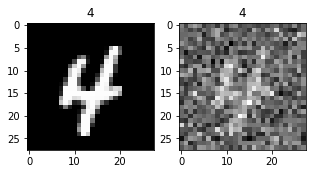

In [ ]:
### Examining the MNIST training dataset ###

idx_train_img = 18787 #@param {type:"slider", min:0, max:59999, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(MNIST.x_train[idx_train_img]),'gray')
plt.title(np.squeeze(MNIST.y_train[idx_train_img])); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(MNIST.x_train_noise[idx_train_img]),'gray')
plt.title(np.squeeze(MNIST.y_train[idx_train_img])); plt.grid(False)

In [ ]:
# Training hyperparameters
roiSize = 28
epochs = 20
batch_size = 100
learning_rate = 1e-4
sample_interval = 50

# Create model
gan = GAN(shape=(roiSize,roiSize,1))

In [ ]:
# Train the model 
gen_loss, dis_loss= train_model(gan, epochs, batch_size=batch_size, learning_rate=learning_rate, sample_interval=sample_interval)

Initializing from scratch.

epoch 1/20
59400/60000 [============================>.] - ETA: 0s - gen_loss: 21.0649 - dis_loss: -7.2056
Saved checkpoint for step 2: ./tf_ckpts/ckpt-1

epoch 2/20
59400/60000 [============================>.] - ETA: 0s - gen_loss: 30.2169 - dis_loss: -2.8494
Saved checkpoint for step 3: ./tf_ckpts/ckpt-2

epoch 3/20
59400/60000 [============================>.] - ETA: 0s - gen_loss: 39.8852 - dis_loss: -2.5592
Saved checkpoint for step 4: ./tf_ckpts/ckpt-3

epoch 4/20
59400/60000 [============================>.] - ETA: 0s - gen_loss: 41.0514 - dis_loss: -1.9049
Saved checkpoint for step 5: ./tf_ckpts/ckpt-4

epoch 5/20
59400/60000 [============================>.] - ETA: 0s - gen_loss: 37.7816 - dis_loss: -1.8215
Saved checkpoint for step 6: ./tf_ckpts/ckpt-5

epoch 6/20
59400/60000 [============================>.] - ETA: 0s - gen_loss: 36.9539 - dis_loss: -1.6548
Saved checkpoint for step 7: ./tf_ckpts/ckpt-6

epoch 7/20
59400/60000 [========================

Text(0.5, 1.0, 'Reconstructed')

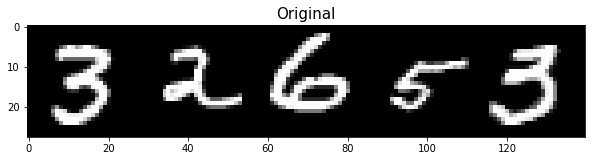

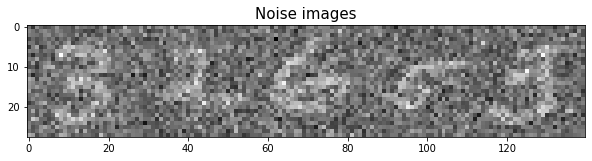

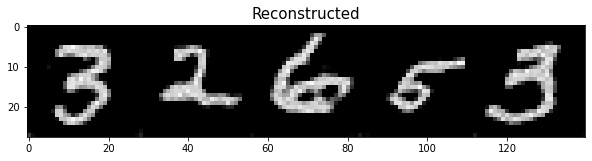

In [ ]:
idx_test_img = 8167 #@param {type:"slider", min:0, max:9999, step:1}

noise = MNIST.x_test_noise[idx_test_img:idx_test_img+5]

img_recon = gan.generator(noise)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack(np.squeeze(MNIST.x_test[idx_test_img:idx_test_img+5])),'gray')
plt.title("Original", fontsize=15)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack(np.squeeze(noise)),'gray')
plt.title("Noise images", fontsize=15)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack(np.squeeze(img_recon)),'gray')
plt.title("Reconstructed", fontsize=15)


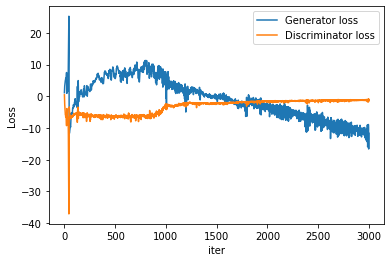

In [ ]:
plt.plot(gen_loss, label="Generator loss")
plt.plot(dis_loss, label="Discriminator loss")
plt.ylabel("Loss")
plt.xlabel("iter")
plt.legend(loc="upper right")

In [ ]:
!rm -rf tf_ckpts/
!rm -rf *.png